In [1]:
import os, sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Import library to read ground truth data
bigdama_path = "/home/andres/CAiN_repos/OutlierDenStream-BigDama18/"
sys.path.append(bigdama_path)

from readGroundTruth import groundTruth

In [3]:
def normalize_matrix(df):
    return (df - df.mean())/df.std()

configuration = json.load(open('configuration.json'))

ControlPlane
Dataset bgpclear_no_traffic_2hourRun
Node:leaf1; entries: 1458
Node:leaf2; entries: 1447
Node:leaf3; entries: 1448
Node:leaf5; entries: 1462
Node:leaf6; entries: 1447
Node:leaf7; entries: 1456
Node:leaf8; entries: 1455
Node:spine1; entries: 1455
Node:spine2; entries: 1438
Node:spine3; entries: 1437
Node:spine4; entries: 1437


(1437, 110)

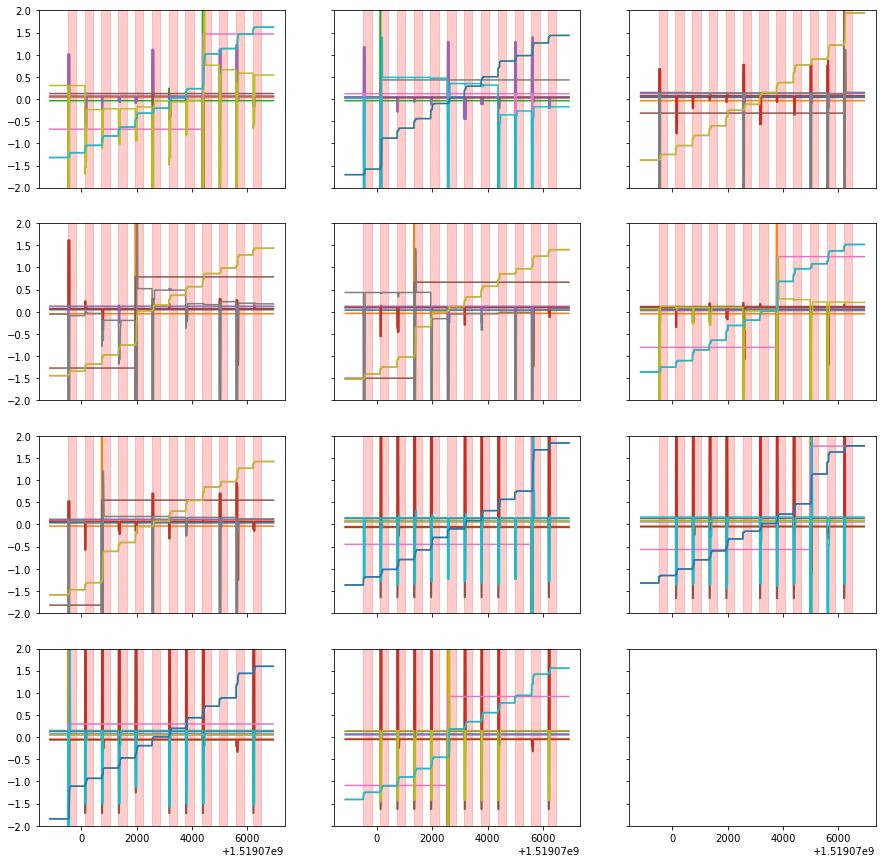

In [4]:
# Read and process Control Plane data

plt.rcParams['figure.figsize'] = [15, 15] # Size of inline plot

def normalize_matrix(df):
    return (df - df.mean())/df.std()

configuration = json.load(open('configuration.json'))
print(configuration['featureModel'])

# Define plot of Control Plane features for all nodes
plot_cols = 3
nbr_datasets = len(configuration['nodes'])
plot_rows = -(-nbr_datasets // plot_cols) # inverse floor-division, equivalent to math.ceil()
fig, axes = plt.subplots(plot_rows, plot_cols, sharex=True, sharey=True)
plot_ctr = 0

# Iterate on all the datasets chosen in the configuration list
for dataset in configuration['dataset']['list']:
    
    print('Dataset {}'.format(dataset))
    telemetry_allLeafs = pd.DataFrame()
    
    # read the ground truth file
    truth = groundTruth(bigdama_path + 'GrounTruth/'+dataset+'.txt', fileType='csv')
    
    # Iterate on all the nodes chosen in the configuration file
    for node in configuration['nodes']:

        # Read node dataset
        df = pd.read_csv(bigdama_path+configuration['dataset']['path']+node+dataset+'.csv', low_memory = False)\
                        .dropna()\
                        .drop('Unnamed: 0', axis=1)
        
        times = pd.DataFrame(columns=['time'])
        times['time'] = df['time'].astype('int')
        df = df.drop(['time'], axis=1)

        # Select the chosen features in the configuration file
        # By default the dataset contains all the features
        # If ControlPlane is chosen: only the CP features are extracted from the dataset
        # If DataPlane is chosen: the CP features are discarded, obtaining a dataset with only DataPlane
        # If CompleteFeatures is chosen: pass
#         if configuration['featureModel'] == 'ControlPlane':
        ## USE CONTROL PLANE FEATURES HERE
        features = 'CP'
        df = df[configuration['featureList']]
#         elif configuration['featureModel'] == 'DataPlane':
#             features = 'DP'
#             df = df.drop(configuration['featureList'], axis=1)
#         elif configuration['featureModel'] == 'CompleteFeatures':
#             features = 'All'
#         else:
#             sys.exit('Something wrong in configuration feature model')

        # Dataset normalization
        df_short = df.loc[:,df.std()!=0]
        dfNormalized = normalize_matrix(df_short).dropna(axis=1)
        del df_short
        
        # Add leaf to allLeafs dataset
        telemetry_allLeafs = pd.concat([telemetry_allLeafs, dfNormalized], axis=1, ignore_index=True).dropna()
        
        print(f"Node:{node}; entries: {len(times)}")
        
        # Write current leaf embeddings to file
        dfNormalized[0:].to_csv('../embeddings/'+dataset+'_'+node+'_'+features+'.emb', index=False, header=False, na_rep=0, sep='\t')
        
        # Create anomaly data
        times['anomaly'] = 0 # add new column
        times['node'] = node

        # Flag entries within anomaly ranges
        for anomaly in truth.events:
            mask = times['time'].between(anomaly['startTime'], anomaly['endTime'])
            times['anomaly'] = times['anomaly'].mask(mask, 1)

        # Write current leaf labels to file
        times[0:].to_csv('../embeddings/'+dataset+'_'+node+'_'+features+'.lbl', index=False, header=True, na_rep=0, sep='\t')
        
        # Plot all features
        plot_x = plot_ctr // plot_cols
        plot_y = plot_ctr % plot_cols
        axes[plot_x, plot_y].plot(times['time'], dfNormalized)
        axes[plot_x, plot_y].set_ylim([-2, 2])

        # Shade the anomaly times
        for anomaly in truth.events:
            axes[plot_x, plot_y].axvspan(anomaly['startTime'], anomaly['endTime'], alpha=0.2, color='red')
        plot_ctr += 1
        
# Print concatenated telemetry
telemetry_allLeafs[0:].to_csv('../embeddings/'+dataset+'_'+features+'.emb', index=False, header=False, na_rep=0, sep='\t')
        
telemetry_allLeafs.shape

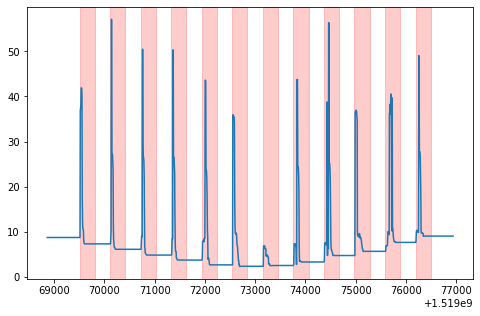

In [5]:
# Create and plot Series with vector length

plt.rcParams['figure.figsize'] = [8, 5] # Size of inline plot

embedding_length = np.sqrt(np.square(telemetry_allLeafs).sum(axis=1))
fig, ax = plt.subplots()

# Plot all features
ax.plot(times['time'][0:len(embedding_length)], embedding_length)
#ax.set_ylim([-3, 3])

# Shade the anomaly times
for anomaly in truth.events:
    ax.axvspan(anomaly['startTime'], anomaly['endTime'], alpha=0.2, color='red')

In [ ]:
# Read and process Control Plane data

plt.rcParams['figure.figsize'] = [15, 15] # Size of inline plot

def normalize_matrix(df):
    return (df - df.mean())/df.std()

configuration = json.load(open('configuration.json'))
print(configuration['featureModel'])

# Define plot of Control Plane features for all nodes
plot_cols = 3
nbr_datasets = len(configuration['nodes'])
plot_rows = -(-nbr_datasets // plot_cols) # inverse floor-division, equivalent to math.ceil()
fig, axes = plt.subplots(plot_rows, plot_cols, sharex=True, sharey=True)
plot_ctr = 0

# Iterate on all the datasets chosen in the configuration list
for dataset in configuration['dataset']['list']:
    
    print('Dataset {}'.format(dataset))
    telemetry_allLeafs = pd.DataFrame()
    
    # read the ground truth file
    truth = groundTruth(bigdama_path + 'GrounTruth/'+dataset+'.txt', fileType='csv')
    
    # Iterate on all the nodes chosen in the configuration file
    for node in configuration['nodes']:

        # Read node dataset
        df = pd.read_csv(bigdama_path+configuration['dataset']['path']+node+dataset+'.csv', low_memory = False)\
                        .dropna()\
                        .drop('Unnamed: 0', axis=1)
        
        times = pd.DataFrame(columns=['time'])
        times['time'] = df['time'].astype('int')
        df = df.drop(['time'], axis=1)

        # Select the chosen features in the configuration file
        # By default the dataset contains all the features
        # If ControlPlane is chosen: only the CP features are extracted from the dataset
        # If DataPlane is chosen: the CP features are discarded, obtaining a dataset with only DataPlane
        # If CompleteFeatures is chosen: pass
#         if configuration['featureModel'] == 'ControlPlane':
#             features = 'CP'
#             df = df[configuration['featureList']]
        ## USE DATA PLANE FEATURES HERE
        features = 'DP'
        df = df.drop(configuration['featureList'], axis=1)
#         elif configuration['featureModel'] == 'DataPlane':
#             features = 'DP'
#             df = df.drop(configuration['featureList'], axis=1)
#         elif configuration['featureModel'] == 'CompleteFeatures':
#             features = 'All'
#         else:
#             sys.exit('Something wrong in configuration feature model')

        # Dataset normalization
        df_short = df.loc[:,df.std()!=0]
        dfNormalized = normalize_matrix(df_short).dropna(axis=1)
        del df_short
        
        # Add leaf to allLeafs dataset
        telemetry_allLeafs = pd.concat([telemetry_allLeafs, dfNormalized], axis=1, ignore_index=True).dropna()
        
        print(f"Node:{node}; entries: {len(times)}")
        
        # Write current leaf embeddings to file
        dfNormalized[0:].to_csv('../embeddings/'+dataset+'_'+node+'_'+features+'.emb', index=False, header=False, na_rep=0, sep='\t')
        
        # Create anomaly data
        times['anomaly'] = 0 # add new column
        times['node'] = node

        # Flag entries within anomaly ranges
        for anomaly in truth.events:
            mask = times['time'].between(anomaly['startTime'], anomaly['endTime'])
            times['anomaly'] = times['anomaly'].mask(mask, 1)

        # Write current leaf labels to file
        times[0:].to_csv('../embeddings/'+dataset+'_'+node+'_'+features+'.lbl', index=False, header=True, na_rep=0, sep='\t')
        
        # Plot all features
        plot_x = plot_ctr // plot_cols
        plot_y = plot_ctr % plot_cols
        axes[plot_x, plot_y].plot(times['time'], dfNormalized)
        axes[plot_x, plot_y].set_ylim([-2, 2])

        # Shade the anomaly times
        for anomaly in truth.events:
            axes[plot_x, plot_y].axvspan(anomaly['startTime'], anomaly['endTime'], alpha=0.2, color='red')
        plot_ctr += 1
        
# Print concatenated telemetry
telemetry_allLeafs[0:].to_csv('../embeddings/'+dataset+'_'+features+'.emb', index=False, header=False, na_rep=0, sep='\t')
        
telemetry_allLeafs.shape

ControlPlane
Dataset bgpclear_no_traffic_2hourRun
Node:leaf1; entries: 1458
Node:leaf2; entries: 1447
Node:leaf3; entries: 1448
Node:leaf5; entries: 1462
Node:leaf6; entries: 1447
Node:leaf7; entries: 1456
Node:leaf8; entries: 1455


In [ ]:
# Create and plot Series with vector length
plt.rcParams['figure.figsize'] = [8, 5] # Size of inline plot

embedding_length = np.sqrt(np.square(telemetry_allLeafs).sum(axis=1))
fig, ax = plt.subplots()

# Plot all features
ax.plot(times['time'][0:len(embedding_length)], embedding_length)
#ax.set_ylim([-3, 3])

# Shade the anomaly times
for anomaly in truth.events:
    ax.axvspan(anomaly['startTime'], anomaly['endTime'], alpha=0.2, color='red')